# Reto: Selección, configuración y entrenamiento del modelo

## Preambulo
### Reto
Este trabajo sigue la competencia de Kaggle de "Titanic - Machine Learning from Disaster", la cual tiene como finalidad servir como introducción al mundo de inteligencia artificial analizando el set de datos de pasajeros del titanic, buscando predecir si un pasajero dado pudo sobrevivir o no basado en caracteristicas como edad, sexo, clase , etc..

Este se trata de un reto de **clasificación**, ya que nos intereza determinar si los pasajeros sobreviven o no, una solución con solo 2 posibles soluciones, o categorica. 

En este archivo, se implementan 4 algoritmos de machine learning buscando resolver este mismo problema, pretendiendo explorar como diferentes métodos de aprendizaje afectan las predicciones, y buscando elejir uno de estos algoritmos para trabajar en mayor refinamiento.

### Trabajo previo
En el entregable anterior se trabajó la limpieza de datos sobre un [dataset](https://www.kaggle.com/c/titanic) que contiene información de los pasajeros a bordo del Titanic. En este esta entrega, se pretende probar diferentes modelos de Marchine Learning con la intención de predecir si un pasajero sobrevivió o no tomando en cuenta caracteristicas como el sexo, edad, familiares a bordo, etc... Puede leer más a acerca de los parametros que se empelan para el entrenamiento y los procesos que se emplearon para la limpieza de datos en [este archivo](https://github.com/4lb3rt0r/TC3006_Equipo2/blob/main/retro/Limpieza%20de%20Datos/clean_training_data.ipynb)
### Objetivos
* Probar diferentes modelos de machine learning que consideramos apropiados para el analisis de este conjunto de datos.
* Evaluar los modelos con la finalidad de seleccionar el que presente un mejor rendimiento.
* Definir un punto de rerencia para tener un objetivo que superar en futuras iteraciones de este trabajo.
* Proveer el código y metodos con la intención de que sean fácilmente replicados y evaluados.

### Importación de dependencias

En este segmento de código se importan las librerías necearias para el procesamiento de datos, entrenamiento de modelos de machine learning, y herramientas para la evaluación del rendimiento de dichos modelos.

In [218]:
# Librerías de uso general
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# Metricas de clasificación
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Librerías de mondelos de ML
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.svm import SVC # Support Vector Machine

### Si utilizas este notebook con Google Colab...

Necesitarás subir el archivo de entrada a Google Drive y montarlo con este código:

In [219]:
# from google.colab import drive
# drive.mount('/content/drive')

### Lectura del archivo de entrenamiento
Como se mencionó anteriormente, puede leer los detalles sobre la limpieza del dataset en [este archivo](https://github.com/4lb3rt0r/TC3006_Equipo2/blob/main/retro/Limpieza%20de%20Datos/clean_training_data.ipynb), pero como resumen, el archivo ``train_clean.csv`` cuenta con las columnas que se consideran relevantes para nuestro analisis, se han eliminado o reemplazado valores nulos y se han convertido variables categoricas relevantes a variables dummy cuantitativas para el analisis.

In [220]:
# En google colab
# trainig_data = pd.read_csv('/content/drive/MyDrive/Equipo 2 - TC3006/Reto - Algoritmos ML/train_clean.csv')
# En local
trainig_data = pd.read_csv('train_clean.csv')

### Descripción de los datos

Con la intención de dar una idea al lector de las caracteristicas del dataset que se trabaja, a continuación se muestran una serie de estadisticas que lo representan; esto incluye el número total de registros, el minimo y máximo de cada variable, su distribución, media, cuartiles, etc.

Tome en cuenta que con variables binarias como *Survived*, *HasCabin* o *IsFemale*, resulta más útil pensar en estadisticas como la media como una proporción de la población que representa estas variables. Por ejemplo, la media de *Survived* es 0.38, lo que indica que con la muestra que se trabaja, el 38% de los pasajeros sobrevivieron al undimiento del titanic. 

In [221]:
print("Numero de registros: ", len(trainig_data.index))

Numero de registros:  891


In [222]:
trainig_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,HasCabin,IsFemale
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,0.228956,0.352413
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,0.420397,0.477990
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000


### Separación de los datos
En esta sección de código se extrae el contenido de variables guardadas en el dataframe hacia arreglos de la librería *numpy*, en el arreglo ``target`` se almacena la variable objetivo *Survived*, es decir, la que nos intereza ser capaces de predecir; mientras que en ``features`` se almacenan las variables de entrada que usaremos para el entrenamiento del modelo. *Pclass, Age, SibSp, Parch, Fare, HasCabin y IsFemale*

En adición a esto, se dividen los datos en 2 conjuntos, uno de entrenamiento que se compone del 80% del conjunto original de los datos y se almacena en las variables ``train_features`` y ``train_targets``, y cun conjunto de datos de prueba que se compone del 20% de los valores originales para probar el desempeño de los modelos, se almacenan en las variables ``test_features`` y ``test_targets``.

Ambos conjuntos se seleccionan de manera aleatoria entre los datos, pero se selecciona una semilla (en este caso *42*) con la finalidad de que los datos sean reproducibles al volver a correr al código. Se utilizan los mismos conjuntos de entrenamiento y prueba para todos los modelos.

In [223]:
target = np.array(trainig_data['Survived'])
features = np.array(trainig_data.drop('Survived', axis = 1))

train_features, test_features, train_targets, test_targets = train_test_split(features, target, test_size = 0.20, random_state = 42)

### Modelos de Machine Learning
A continuación se encuentran 4 secciones, cada una correspondiente a uno de los modelos de machine learning que decidimos implementar, estos son:

* Decision Tree
* Random Fores
* Neural Network
* Support Vector Machine

En cada sección se explica de manera breve la idea y funcionamiento de los mismos, la implementación del modelo utilizando librerías de **sklearn**, el uso del modelo recién entrenado sobre el conjunto de datos de prueba y el analisis del rendimiento del modelo usando la matriz de confusión y las metricas de exactitud, presición, sensibilidad y F1.

### Métricas de desempeño

Para evaluar el rendimiento de nuestro modelo, hemos decidido elegir las métricas o indicadores más convencionales para medir el rendimiento y la fiabilidad del mismo, que son las siguientes:

* Matriz de Confusión (*Confusion Matrix*): La matriz de confusión es una tabla que provee una descripción detallada del rendimiento del modelo al proyectar las cuentas de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos. Además, permite identificar errores específicos que el modelo presenta. Este recurso resulta ser muy valioso, especialemente cuando se necesita evaluar y mejorar el rendimiento del modelo.

$$TP = \text{Verdaderos positivos}$$ 
$$FP = \text{Falsos positivos}$$ 
$$TN = \text{Verdaderos Negativos}$$ 
$$FN = \text{Falsos Negativos}$$ 

* Exactitud (*Accuracy*): Este mide la proporción de instancias que fueron clasficadas correctamente del resto por el modelo. Básicamente, proporciona una medida general de cómo es que el modelo, en términos de clasificar correctamente tanto verdaderos positivos y verdaderos negativos.

$$Accuracy = \frac{{TP + TN}}{{TP + TN + FP + FN}}$$

* Precisión (*Precision*): Mide la precisión del modelo con respecto a predicciones positivas. Da respuesta a la pregunta "De todas las instancias estimadas por el modelo ¿cuántas de ellas fueron positivas?" Entre mayor sea este valor, indica que el modelo es bueno al evitar falsos positivos.

$$Precision = \frac{{TP}}{{TP + FP}}$$

* Exhaustividad (*Recall*): Este mide la habilidad del modelo para identificar todas las instancias relevantes dentro del dataset. Un valor de "recall" alto indica que el modelo raramente se equivoca en casos positivos. Esta métrica es importante cuando los casos positivos faltantes son bastante costosos, un ejemplo serían diagnósticos médicos.

$$Recall = \frac{{TP}}{{TP + FN}}$$

* Valor F1 (*F1-Score*): La métrica F1 es la media armónica de la precisión con respecto a la exhaustividad. Este condensa el intercambio de precision con recall en una sola misma métrica. Un alto valor de "F1-Score" indica que el modelo demuestra un rendimiento destacado en términos de las variables que considera (precision y recall) Resulta muy útil cuando se busca balancear la precision y la exhaustividad o bien para identificar una distribución de métrcias desigual.

$$F1 = \frac{{2 \cdot Precision \cdot Recall}}{{Precision + Recall}}$$

#### Métrica de desempeño para pruebas

Decidimos emplear el **valor F1 del confjunto de predicciones de prueba** como metrica definitiva de desempeño para nuestras pruebas. Tomamos esta desición porque este valor suele ser utilizado cuando los resultados falsos tienen implicaciones pesadas, en este caso, considerando que declarar o muerto a un pasajero sería una afirmación de gran peso en caso de que se utilizara un modelo similar a este en caso de un incidente similar al del Titanic. En adición a esto, su uso es recomendado en casos donde una categoría es considerablemente más frecuente que la otra, en este caso, el número de pasajeros fallecidos supera en número al de supervivientes en una relación 2 a 1, siendo que casi 2 tercios de los pasajeros fallecieron durante el undimiento.

Se utiliza el conjunto de **Prueba** para tomar la desición ya que consideramos que representa mejor la capacidad de generalización de datos de los modelos, esto evita situaciones en los que la varianza del modelo sea alta y el modelo resulte tener *overfitting* con datos observados previamente y no pueda aadptarse a datos del conjunto de testing de la competencia.

En el código a continuación se utilizan metodos implementados por scikit learn para el calculo y despliegue de los valores descritos anteriormente.

In [224]:
def display_model_metrics(data, pred):
    conf_matrix = confusion_matrix(data, pred)

    print("Confusion Matrix:")

    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Survived', 'Survided'],
                yticklabels=['Not Survided', 'Survided'])

    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de confusión')
    plt.show()

    accuracy = accuracy_score(data, pred)
    print(f'Exactitud : {accuracy*100}%')
    precision = precision_score(data, pred)
    print(f'Precisión : {precision*100}%')
    recall = recall_score(data, pred)
    print(f'Sensibilidad : {recall*100}%')
    f1 = f1_score(data, pred)
    print(f'F1 : {f1*100}%')

### Planeación de pruebas

Con la finalidad de acercarnos a una versión más refinada de cada modelo, se generarán diferentes variaciones de los mismos variando sus hiper parametros, buscando acercarnos a aquellos que proporcionan mejores resultados. En esta sección, puede encontrar los hiper parametros que se emplean en cada prueba, y en la sección correspondiente a cada modelo puede encontrar los resultados de dichas pruebas.

#### Decision Tree

| Prueba   | max_depth | min_samples_split |
|----------|-----------|-------------------|
| Prueba 1 | None      | 2                 |
| Prueba 2 | 5         | 5                 |
| Prueba 3 | 10        | 10                |
| Prueba 4 | 15        | 10                |

#### Random Forest

| Prueba   | n_estimators |
|----------|--------------|
| Prueba 1 | 5            |
| Prueba 2 | 10           |
| Prueba 3 | 50           |
| Prueba 4 | 100          |

#### Redes neuronales
En el caso de redes neuronales, debido a la cantidad de hiper parametros modificables, se optó por modificar solamente la cantidad de neuronas en la primera capa. Los demás parametros se mantienen contantes a lo largo de todas las pruebas. La función de activación de la primera y segunda capa es **relu** y de la tercera es la **función sigmoide**; la segunda capa cuenta con **5 neuronas** y la tercera con **10 neuronas**, además, todos los modelos se entrenaron usando **50 iteraciones**.

| Prueba   | Primer Capa |
|----------|-------------|
| Prueba 1 | 1           |
| Prueba 2 | 2           |
| Prueba 3 | 3           |
| Prueba 4 | 4           |
| Prueba 5 | 10          |
| Prueba 6 | 50          |

#### Support Vector Machine
| Prueba   | Tipo de Kernel |
|----------|----------------|
| Prueba 1 | Lineal         |
| Prueba 2 | Polinomial     |
| Prueba 3 | Sigmoidal      |
| Prueba 4 | rbf            |

## Decision Tree
El algoritmo de Decision Tree (o arboles de desición) es un a técnica de machine learning que consiste en el uso de reglas de desición simple, de forma similar a un diagrama de flujo, aprendidas de un conjunto de datos con la finalidad de predecir valores tomando en cuenta esos mismos parametros. Consideramos que este es un algoritmo apto para este problema dado que podemos aprovechar de las marcadas divisiones categoricas que tenemos en nuestro conjunto de datos, como sexo, edad, clase, etc... De forma intuitiva, el modelo preguntaría ¿El pasajero era hombre o mujer? ¿Era niño o adulto? ¿Viajaba en primera clase? y con esto llegaría a una respuesta tomando en cuenta estos valores, asociando un peso diferente a cada variable.

### Creación del modelo

In [225]:
dt = DecisionTreeClassifier(max_depth= 10, min_samples_split=10, random_state = 42)
dt.fit(train_features, train_targets)

DecisionTreeClassifier(max_depth=15, min_samples_split=10, random_state=42)

### Predicciones

In [226]:
y_pred = dt.predict(test_features)

### Análisis de resultados

Confusion Matrix:


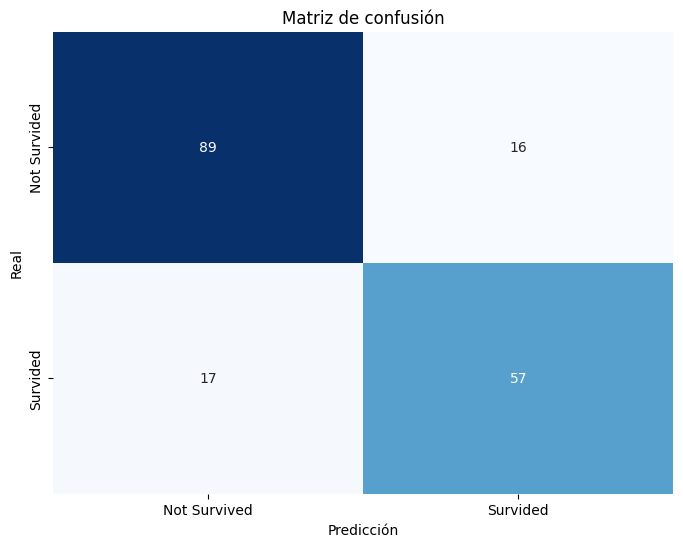

Exactitud : 81.56424581005587%
Precisión : 78.08219178082192%
Sensibilidad : 77.02702702702703%
F1 : 77.55102040816327%


In [227]:
display_model_metrics(test_targets, y_pred)

### Tabla Comparativa de Resultados

La tabla siguiente presente los resultados de diferentes iteraciones del modelo, cambiando los parametros de inicio con la finaldiad de encontrar el que mejor se ajuste a la solución.

| Prueba   | TN | FP | FN | TP | Exactitud | Precisión | Sensibilidad | F1    |
|----------|----|----|----|----|-----------|-----------|--------------|-------|
| Prueba 1 | 85 | 20 | 20 | 54 | 77.65%    | 72.97%    | 72.97%       | 72.97%|
| Prueba 2 | 95 | 10 | 25 | 49 | 80.45%    | 83.05%    | 66.22%       | 73.68%|
| Prueba 3 | 92 | 13 | 19 | 55 | 82.12%    | 80.88%    | 74.32%       | 77.46%|
| Prueba 4 | 89 | 16 | 17 | 57 | 81.56%    | 78.08%    | 77.02%       | 77.55%|


## Random Forest
Random Forest (o bosques aleatorios) es un algoritmo que consiste en el uso de *n* arboles de desición con la finalidad de reducir el ruido presente en un solo arbol, evitar el overfitting, y tomar en cuenta una mayor variabilidad entre los datos; ofreciendo una mayor calidad de los datos a costa de un mayor precio computacional, pero esto no se trata de un problema para fines de este reto dado que trabajamos con un conjunto de datos relativamente pequeño (menor a 1000 filas de datos).

### Creación del modelo

In [228]:
rf = RandomForestClassifier(n_estimators = 5, random_state = 42)
rf.fit(train_features, train_targets);

### Predicciones

In [229]:
y_pred = rf.predict(test_features)

### Análisis de resultados

Confusion Matrix:


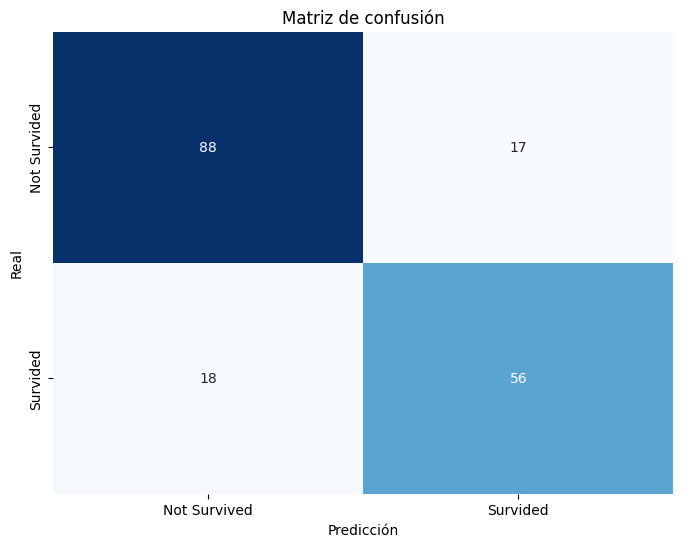

Exactitud : 80.44692737430168%
Precisión : 76.71232876712328%
Sensibilidad : 75.67567567567568%
F1 : 76.1904761904762%


In [230]:
display_model_metrics(test_targets, y_pred)

### Tabla Comparativa de Resultados

De nuevo, la tabla siguiente presente los resultados de diferentes iteraciones del modelo, cambiando los parametros de inicio con la finaldiad de encontrar el que mejor se ajuste a la solución.

| Prueba   | n_estimators | random_state | TN | FP | FN | TP | Exactitud | Precisión | Sensibilidad | F1    |
|----------|--------------|--------------|----|----|----|----|-----------|-----------|--------------|-------|
| Prueba 1 | 5            | 42           | 88 | 17 | 18 | 56 | 80.44%    | 76.71%    | 75.67%       | 76.19%|
| Prueba 2 | 10           | 42           | 88 | 17 | 21 | 53 | 79.89%    | 77.14%    | 72.97%       | 75.00%|
| Prueba 3 | 50           | 42           | 89 | 16 | 20 | 54 | 79.88%    | 77.14%    | 72.97%       | 75.00%|
| Prueba 4 | 100          | 42           | 88 | 17 | 20 | 54 | 79.33%    | 76.06%    | 72.98%       | 74.48%|


## Redes neuronales
Las redes neuronales son modelos computacionales inspirados en el comportamiento del cerebro biológico. Consisten en valores de entrada, que en este caso son variables del archivo ```train_clean.csv``` de pasajeros del Titanic. Estos valores pasan por neuronas, a las cuales se les asignan pesos para cada variable. La suma ponderada se procesa con una función matemática, llamada función de activación, para producir la salida final de la neurona.

Este proceso puede repetirse en múltiples capas, potencialmente obteniendo mejores resultados que un enfoque de una sola capa y neurona. Sin embargo, contar con suficientes datos de entrada es crucial para predicciones o clasificaciones precisas.

En el contexto del reto, se eligen las redes neuronales debido a su capacidad de clasificación con datos binarios (0, 1), donde 1 representa supervivencia y 0 no supervivencia. Entre varios modelos, las redes neuronales muestran una mayor precisión debido a su comprensión de la jerarquía de variables, aprendizaje más rápido y configuraciones versátiles. En última instancia, el éxito depende del contexto del problema y encontrar configuraciones óptimas.

### Normalización de los Datos
Normalizamos los datos y nos aseguramos de que posean una media de $\mu$ = 0 y desviación estándar de $\sigma$ = 1. Esto con el fin de mejorar el rendimiento y estabilidad de la red neuronal durante los procesos de entrenamiento y predicción.

In [231]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

### Creación del Modelo
En primera instancia, obtenemos la cantidad de variables que serán tomadas en cuenta para introducir en el modelo, en nuestro caso se trata de 7 variables distintas a considerar.

Después procedemos a crear el modelo de redes neuronales, del cual colocamos 3 capas, 2 con una cantidad fija de neuronas y la primera que utilizamos para variar los resultados de las predicciones. La estructura de la red neuronal no tiene otra explicaicón o significado más que probar de forma práctica el comportamiento de la misma:

In [232]:
caracteristic_number = train_features_scaled.shape[1] # Calcula el número de características (variables a introducir al modelo)

model = keras.Sequential([
    keras.layers.Dense(50, activation='relu', input_shape=(caracteristic_number,)),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid') # Sin función de activación en la capa de salida para estimación numérica
])

### Compilamos la Red Neuronal

In [233]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

### Realizamos el Entrenamiento
De igual manera que con la estructura de la red neuronal, la cantidad de iteraciones claro que puede ser cambiada, sin embargo y de momento, la mantendremos constante con un valor de 50 para reducir el rango de posibilidades para probar el modelo y comprender cómo se comporta:

In [234]:
model.fit(train_features_scaled, train_targets, epochs=50, batch_size=32)

Epoch 1/50
23/23 [==============================] - 0s 651us/step - loss: 0.2567 - accuracy: 0.0126
Epoch 2/50
23/23 [==============================] - 0s 702us/step - loss: 0.2524 - accuracy: 0.0028
Epoch 3/50
23/23 [==============================] - 0s 467us/step - loss: 0.2487 - accuracy: 0.0098
Epoch 4/50
23/23 [==============================] - 0s 417us/step - loss: 0.2455 - accuracy: 0.0421
Epoch 5/50
23/23 [==============================] - 0s 347us/step - loss: 0.2424 - accuracy: 0.0534
Epoch 6/50
23/23 [==============================] - 0s 355us/step - loss: 0.2394 - accuracy: 0.0632
Epoch 7/50
23/23 [==============================] - 0s 345us/step - loss: 0.2363 - accuracy: 0.2360
Epoch 8/50
23/23 [==============================] - 0s 348us/step - loss: 0.2330 - accuracy: 0.2570
Epoch 9/50
23/23 [==============================] - 0s 347us/step - loss: 0.2297 - accuracy: 0.2598
Epoch 10/50
23/23 [==============================] - 0s 401us/step - loss: 0.2262 - accuracy: 0.2725

23/23 [==============================] - 0s 431us/step - loss: 0.1804 - accuracy: 0.7753
Epoch 26/50
23/23 [==============================] - 0s 457us/step - loss: 0.1784 - accuracy: 0.7374
Epoch 27/50
23/23 [==============================] - 0s 431us/step - loss: 0.1762 - accuracy: 0.7219
Epoch 28/50
23/23 [==============================] - 0s 406us/step - loss: 0.1741 - accuracy: 0.6910
Epoch 29/50
23/23 [==============================] - 0s 354us/step - loss: 0.1721 - accuracy: 0.6770
Epoch 30/50
23/23 [==============================] - 0s 418us/step - loss: 0.1700 - accuracy: 0.6742
Epoch 31/50
23/23 [==============================] - 0s 413us/step - loss: 0.1679 - accuracy: 0.6559
Epoch 32/50
23/23 [==============================] - 0s 400us/step - loss: 0.1656 - accuracy: 0.6278
Epoch 33/50
23/23 [==============================] - 0s 426us/step - loss: 0.1630 - accuracy: 0.6194
Epoch 34/50
23/23 [==============================] - 0s 2ms/step - loss: 0.1606 - accuracy: 0.6222
Epoc

### Predicciones

In [235]:
predictions = model.predict(test_features_scaled)

survided_predictions = predictions[:, 1]

y_pred = [1 if prob >= 0.5 else 0 for prob in survided_predictions]

6/6 [==============================] - 0s 450us/step


### Análisis de Resultados

Confusion Matrix:


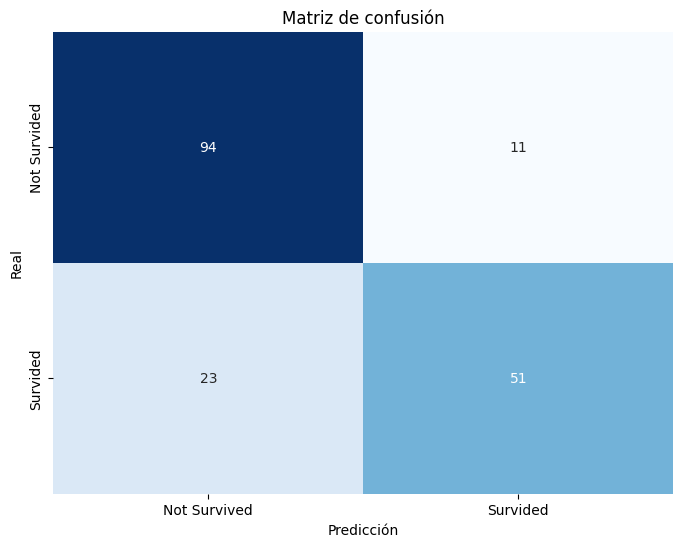

Exactitud : 81.00558659217877%
Precisión : 82.25806451612904%
Sensibilidad : 68.91891891891892%
F1 : 75.0%


In [236]:
display_model_metrics(test_targets, y_pred)

### Tabla Comparativa de Resultados
| Prueba   | Accuracy | Precision | Recall  | F1 Score |
|----------|----------|-----------|---------|----------|
| Prueba 1 | 75.98%   | 68.67%    | 77.03%  | 72.61%   |
| Prueba 2 | 81.01%   | 74.39%    | 82.43%  | 78.21%   |
| Prueba 3 | 78.77%   | 75.71%    | 71.62%  | 73.61%   |
| Prueba 4 | 79.33%   | 78.46%    | 68.92%  | 73.38%   |
| Prueba 5 | 79.33%   | 78.46%    | 68.92%  | 73.38%   |
| Prueba 6 | 82.12%   | 82.81%    | 71.62%  | 76.81%   |



## Support Vector Machine
Support Vector Clasification es uno de los algoritmos de clasificación más simples, pero que puede llegar a tener muy buenos resultados. La manera en la que funciona es toma un plano donde se grafica  2 variables, en nuestro caso si el pasajero sobrevivió o murió, luego genera una línea para clasificar los variables. En nuestro caso se toman en cuenta más de dos features para hacer la clasificación, así que se grafica en un plano de múltiples dimensiones y el hiperplano es un plano que divide los puntos entre las dos clases que queremos encontrar.

### Creación del modelo

In [237]:
#Kernels: 'sigmoid', 'poly', 'linear', 'rbf'
svm = SVC(kernel='linear', random_state=50)
svm.fit(train_features, train_targets);

### Predicciones

In [238]:
y_pred = svm.predict(test_features)

### Análisis de resultados

Confusion Matrix:


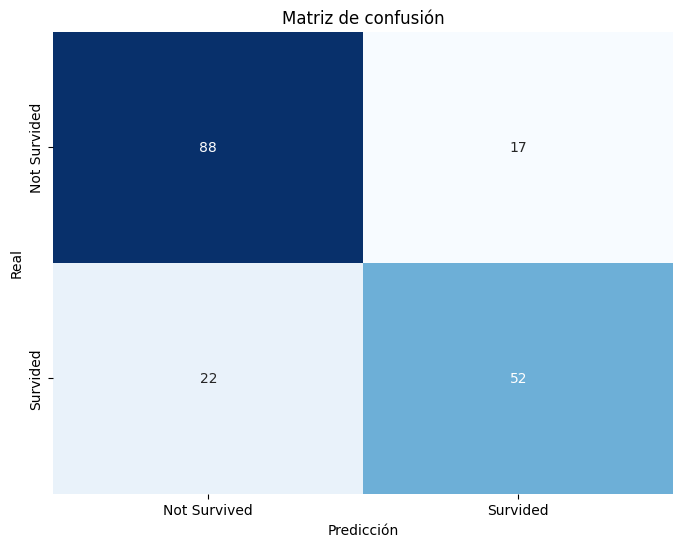

Exactitud : 78.2122905027933%
Precisión : 75.36231884057972%
Sensibilidad : 70.27027027027027%
F1 : 72.72727272727273%


In [239]:
display_model_metrics(test_targets, y_pred)

### Tabla comparativa de resultados
| Prueba   | TN | FP | FN | TP | Exactitud | Precisión | Sensibilidad | F1    |
|----------|----|----|----|----|-----------|-----------|--------------|-------|
| Prueba 1 | 88 | 17 | 22 | 52 | 78.21%    | 75.36%    | 70.27%       | 72.73%|
| Prueba 2 |103 | 2  | 66 | 8  | 62.01%    | 80.00%    | 10.81%       | 19.05%|
| Prueba 3 | 74 | 31 | 37 | 37 | 62.01%    | 54.41%    | 50.00%       | 52.11%|
| Prueba 4 | 99 | 6  | 56 | 18 | 65.36%    | 75.00%    | 24.32%       | 36.73%|


## Resultados finales

A continuación, se tabulan los mejores resultados obtenidos de cada algoritmo, con la finalidad de comparar su desempeño.

| Modelo              | Prueba  | Exactitud | Precisión | Sensibilidad | F1    |
|---------------------|---------|-----------|-----------|--------------|-------|
| Decision Tree       | Prueba 3| 82.12%    | 80.88%    | 74.32%       | 77.46%|
| Random Forest       | Prueba 1| 80.44%    | 76.71%    | 75.67%       | 76.19%|
| Redes Neuronales    | Prueba 2| 81.01%    | 74.39%    | 82.43%       | 78.21%|
| SVM                 | Prueba 1| 78.21%    | 75.36%    | 70.27%       | 72.72%|



## Conclusión

Tomando en cuenta todos los modelos implementados, su implementación y comparando los resultados arrojados por los mismos en base al mismo conjunto de datos, concluimos que de todos los algoritmos de Machine Learning que elegimos, las redes neuronales resultaron ser las que presentaron mejores resultados. Algunos modelos como árboles de decisión o Random Forest son algoritmos que lograron resultados aproximados al **80%** de precisión y exactitud, equivocándose de una forma moderada en cuanto a sus resultados. Sin embargo, las redes neuronales presentaron un mejor rendimiento, y esto lo vemos claramente reflejado en las métricas que utilizamos para evaluarlo, siendo que llega al **80%** de precisión y exactitud aproximadamente.

Por otro lado, el Support Vector Machine arrojó resultados bastante peculiares, ya que en conjunto como equipo no estábamos seguros de recibir buenos resultados por parte de este algoritmo. A pesar de ello, logró colocarse entre el **70%** y **75%** de precisión y exactitud de las predicciones que realizó, sin embargo, no logró superar el rendimiento de los demás modelos, por ende, este modelo muy probablemente se descarte para posteriores entregas. Finalmente, nos quedamos con 3 modelos que, en este momento, no estamos completamente seguros de que los datos arrojados por los mismos sean realmente concisos y persistentes si se utilizara un dataset con un formato similar, pero con datos distintos. Para próximas entregas, se buscará complementar estos modelos, analizando su rendimiento, resultados y lo más importante, refinar dichos algoritmos con el fin de obtener la mejor versión de cada uno que se adapte al problema planteado. Pese a no poder llegar a conclusiones muy claras, posiblemente el camino correcto para resolver la problemática se encuentra entre las redes neuronales, o bien en los árboles de decisión.